In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Research/CS_4650_HSD/Code/'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Research/CS_4650_HSD/Code
BERT_Vanilla.ipynb					     real_dataset
contextualizing-hate-speech-models-with-explanations-master


In [2]:
!pip install transformers

# Import

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GHC

## Basic Info

In [4]:
ghc_df = pd.read_csv('real_dataset/ghc_train.tsv', delimiter='\t')
ghc_df.head()

,Unnamed: 0,text,is_hate
0,592,"Watch the water slowly rise with me, lads! Edg...",0
1,6352,"It's a big ol' mess, eh? They're trying, and t...",0
2,2684,"No, he actually broke the law - hence why he's...",0
3,17427,ASSET FORFEITURE is LEGALIZED THEFT!,0
4,15295,this makes my blood boil my poor dad gave his ...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'hate')

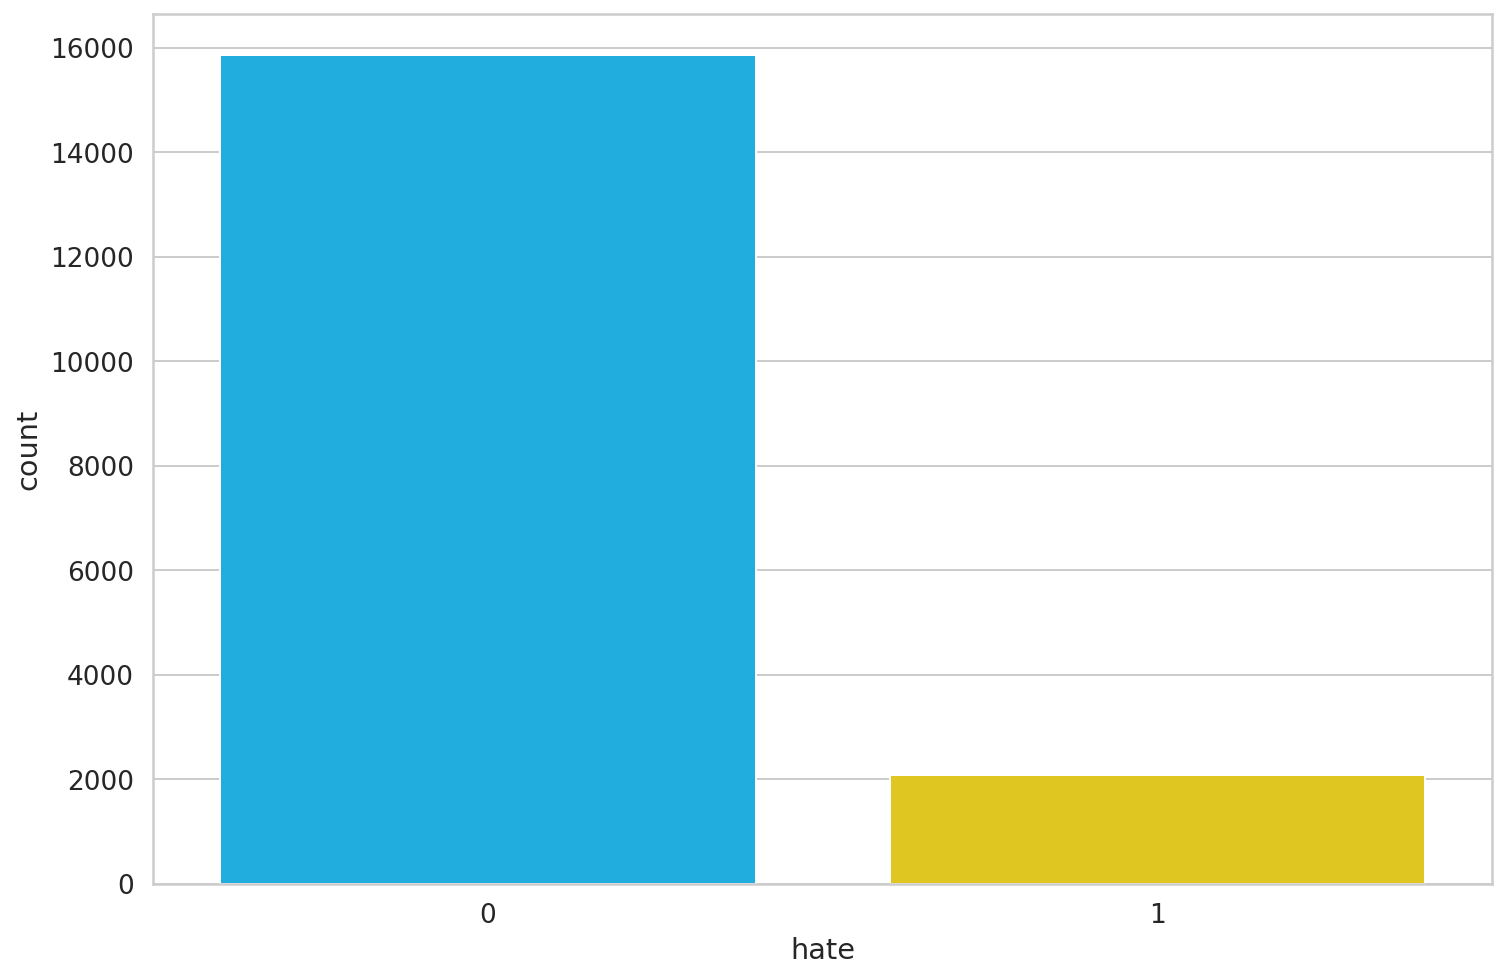

In [5]:
sns.countplot(ghc_df['is_hate'])
plt.xlabel('hate')

## Load tokenizer and model

In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Choose sequence length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

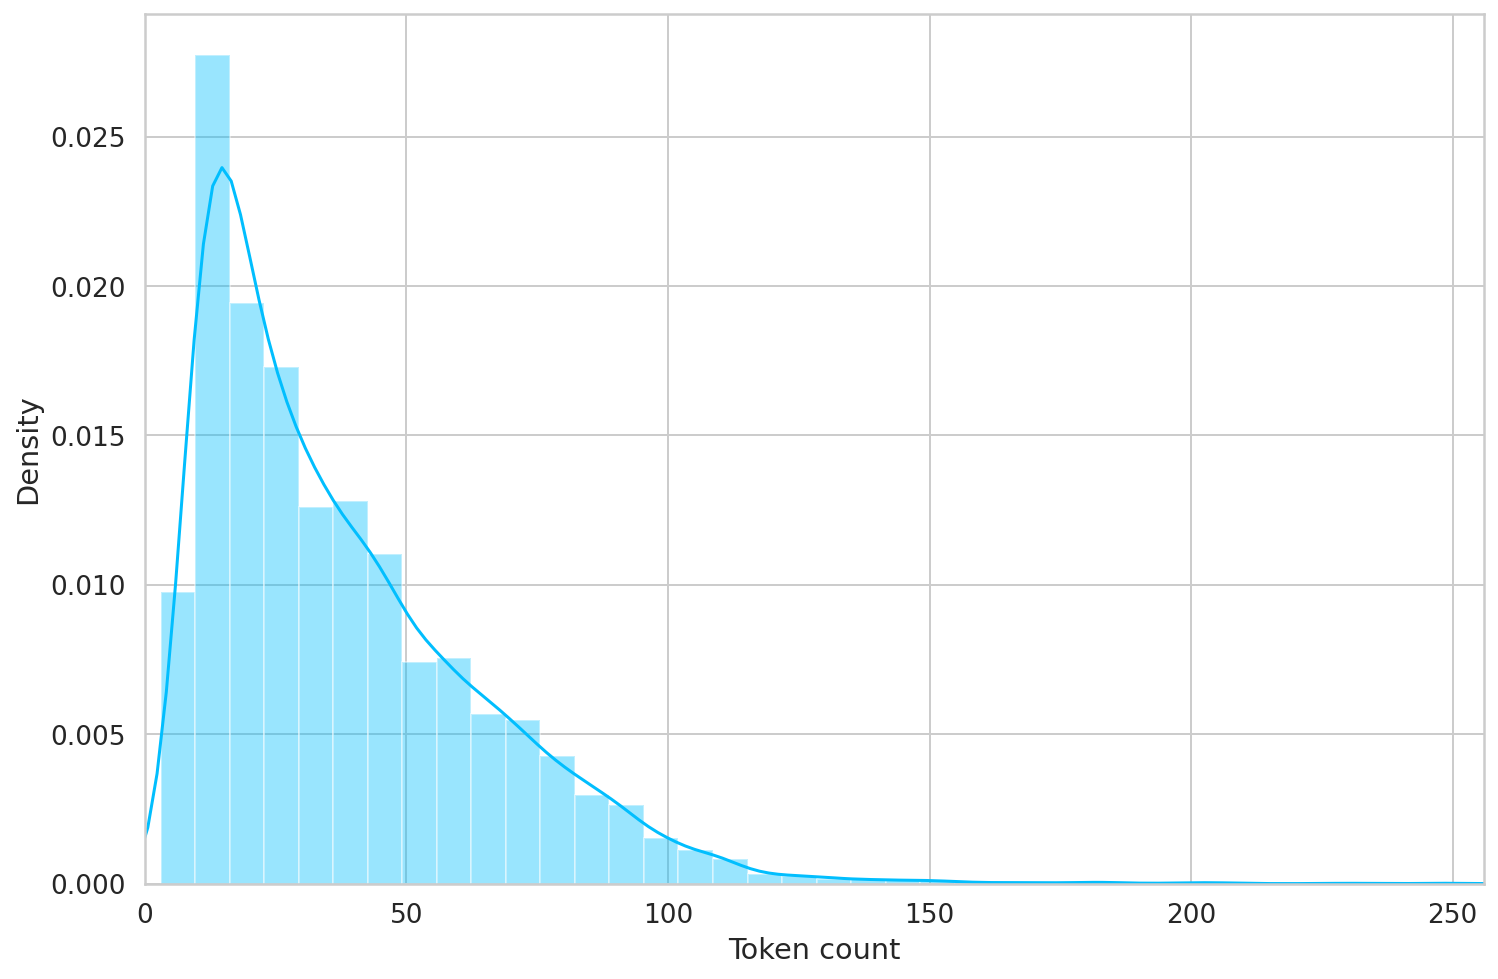

In [7]:
token_lens = []
for txt in ghc_df['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

## Create dataset

In [8]:
class GHCDataset(Dataset):
    
    def __init__(self, txt, targets, tokenizer, max_len):
        self.txt = txt
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.txt)

    def __getitem__(self, item):
        txt = str(self.txt[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            # padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
    
        return {
            'text': txt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

## Split train, val, test
Note: this is just for testing. We should create 3 individual train, val, test files

In [9]:
df_train = pd.read_csv('real_dataset/ghc_train.tsv', delimiter='\t')
df_val = pd.read_csv('real_dataset/ghc_val.tsv', delimiter='\t')
df_test = pd.read_csv('real_dataset/ghc_test.tsv', delimiter='\t')

In [10]:
df_train.shape, df_val.shape, df_test.shape

((17932, 3), (2241, 3), (2242, 3))

## Create data loader

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GHCDataset(
        txt=df['text'].to_numpy(),
        targets=df['is_hate'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

## Load data

In [12]:
BATCH_SIZE = 16
MAX_LEN = 256
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Create model

In [14]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Create classifier

In [15]:
class GHCClassifier(nn.Module):

    def __init__(self, n_classes):
        super(GHCClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        pooled_output = output.pooler_output
        output = self.out(pooled_output)
        return self.softmax(output)

In [16]:
model = GHCClassifier(2)
model = model.to(device)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
model(input_ids, attention_mask)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.4596, 0.5404],
        [0.5192, 0.4808],
        [0.4698, 0.5302],
        [0.4419, 0.5581],
        [0.4832, 0.5168],
        [0.4408, 0.5592],
        [0.4508, 0.5492],
        [0.4469, 0.5531],
        [0.4361, 0.5639],
        [0.4334, 0.5666],
        [0.5087, 0.4913],
        [0.4583, 0.5417],
        [0.4746, 0.5254],
        [0.4449, 0.5551],
        [0.4496, 0.5504],
        [0.4694, 0.5306]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Train

In [17]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

## Stormfront

In [ ]:
ghc_df = pd.read_csv('real_dataset/stormfront_train.tsv', delimiter='\t')
ghc_df.head()

In [ ]:
sns.countplot(ghc_df['is_hate'])
plt.xlabel('hate')

In [ ]:
token_lens = []
for txt in ghc_df['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [ ]:
class StormfrontDataset(Dataset):
    
    def __init__(self, txt, targets, tokenizer, max_len):
        self.txt = txt
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.txt)

    def __getitem__(self, item):
        txt = str(self.txt[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            txt,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            # padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
    
        return {
            'text': txt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train = pd.read_csv('real_dataset/stormfront_train.tsv', delimiter='\t')
df_val = pd.read_csv('real_dataset/stormfront_val.tsv', delimiter='\t')
df_test = pd.read_csv('real_dataset/stormfront_test.tsv', delimiter='\t')

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = StormfrontDataset(
        txt=df['text'].to_numpy(),
        targets=df['is_hate'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 256
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class StormfrontClassifier(nn.Module):

    def __init__(self, n_classes):
        super(StormfrontClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        pooled_output = output.pooler_output
        output = self.out(pooled_output)
        return self.softmax(output)

In [ ]:
model = StormfrontClassifier(2)
model = model.to(device)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
model(input_ids, attention_mask)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc